# Teoria Moderna do Portfólio em Python
 _Baseado [nesse artigo do Medium](https://medium.com/turing-talks/teoria-moderna-do-portf%C3%B3lio-em-python-e8bad41ebb8b)_


# Risk Parity - Backtesting

### Premissas

- Capital inicial de R$100.000,00
- Rebalanceamento a cada 3 meses de acordo com a estratégia de Risk Parity
- Simular investimentos de 01/01/2021 até 01/07-2023
- Sem custo de rebalanceamento
- A cada rebalanceamento considerar os dados dos últimos 5 anos
- Ativos:
    - Bancos:  ITUB4.SA, SANB4.SA, BBAS3.SA, BBDC4.SA
    - Energia: TRPL4.SA, EGIE3.SA, AESB3.SA
    - Saneamento: SAPR11.SA, SBSP3.SA, CSMG3.SA

### Algoritmo

1. Gerar datas de rebalanceamento
1. Para cada data de rebalanceamento
    1. Calcular a melhor carteira de acordo com Risk Parity utilizando os dados dos últimos PW anos, armazenando-a
    1. Simular retorno da carteira calculada até a próxima data de rebalanceamento, armazenando-a


Parâmetros
* PW: Past Window, período de tempo no passado que será utilizado para calcular o peso da carteira (ex: 5 anos)
* RP: Rebalancing Period, período em que será feito o rebalanceamento (ex: 3 Meses)
* Tickers: Ativos que irão compor a carteira
* Start_date e End_date


### Preliminares

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import turingquant as tq
import yfinance as yf
import seaborn as sns

In [8]:
tickers = ['ITUB4.SA', 'SANB4.SA', 'BBAS3.SA', 'BBDC4.SA',
'TRPL4.SA', 'EGIE3.SA', 'AESB3.SA', 
'SAPR11.SA', 'SBSP3.SA', 'CSMG3.SA']

In [9]:
def matrix_seriation(retornos: pd.DataFrame):
    matriz_cov = retornos.cov()
    dendograma = sns.clustermap(matriz_cov, method='ward', metric='euclidean')
    colunas_seriation = dendograma.dendrogram_col.reordered_ind
    colunas_seriation = retornos.columns[colunas_seriation]
    return (matriz_cov, colunas_seriation)

In [10]:
def calcula_pesos_hrp(matriz_cov, colunas_seriation):
    # Inicialização de pesos
    pesos = pd.Series(1, index=colunas_seriation)
    paridades = [colunas_seriation]

    while len(paridades) > 0:
        # Instanciação de clusters
        paridades = [cluster[inicio:fim] 
                     for cluster in paridades
                      for inicio, fim in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster)))
                        if len(cluster) > 1]

        # Iteração entre paridades
        for subcluster in range(0, len(paridades), 2):
            
            cluster_esquerdo = paridades[subcluster]
            cluster_direito = paridades[subcluster + 1]
            
            matriz_cov_esquerda = matriz_cov[cluster_esquerdo].loc[cluster_esquerdo]
            inversa_diagonal = 1 / np.diag(matriz_cov_esquerda.values)
            pesos_cluster_esquerdo = inversa_diagonal / np.sum(inversa_diagonal)
            vol_cluster_esquerdo = np.dot(pesos_cluster_esquerdo, np.dot(matriz_cov_esquerda, pesos_cluster_esquerdo))

            matriz_cov_direita = matriz_cov[cluster_direito].loc[cluster_direito]
            inversa_diagonal = 1 / np.diag(matriz_cov_direita.values)
            pesos_cluster_direito = inversa_diagonal  / np.sum(inversa_diagonal)
            vol_cluster_direito = np.dot(pesos_cluster_direito, np.dot(matriz_cov_direita, pesos_cluster_direito))

            fator_alocacao = 1 - vol_cluster_esquerdo / (vol_cluster_esquerdo + vol_cluster_direito)

            pesos[cluster_esquerdo] *= fator_alocacao
            pesos[cluster_direito] *= 1 - fator_alocacao
            
    return pesos

#### Utilitários

In [22]:
import time
import pandas as pd
from typing import List
import yfinance as yf
from datetime import datetime, timedelta


# Decorador para cronometrar tempo de execução
# Não deve ser utilizado em funções recursivas
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        execution_time = end_time - start_time
        print(f"Function '{func.__name__}' took {execution_time:.6f} seconds to execute.")
        return result
    return wrapper

class Params:
    def __init__(self, tickers: List[str], start_date: str, end_date: str) -> None:
        self.df = yf.download(tickers, start=start_date, end=end_date)
        self.df.index = pd.to_datetime(self.df.index)
        self.tickers : pd.DataFrame = tickers
        self.start_date : pd.DataFrame = start_date
        self.end_date : pd.DataFrame = end_date
        self.adj_close : pd.DataFrame = self.df['Adj Close']
        self.close : pd.DataFrame = self.df['Close']
        self.high : pd.DataFrame = self.df['High']
        self.low : pd.DataFrame = self.df['Low']
        self.open : pd.DataFrame = self.df['Open']
        self.volume : pd.DataFrame = self.df['Volume']
        self.returns_daily = self.adj_close.pct_change().fillna(0)  # Retornos diários
        self.returns_monthly = self.adj_close.pct_change(20).fillna(0).resample('BM').last().ffill()  # Retornos mensais

#### Backtesting

In [35]:
import pandas as pd
import seaborn as sns

class RiskParityBacktesting:
    """
    Classe que implementa backtesting utilizando a estratégia de Markowitz

    Parâmetros
    ----------

    tickers: List[str]
        lista de tickers dos ativos que compõem a carteira a ser simulada
    start_date: str
        string no formato %Y-%m-%d que representa o início do período simulado Ex: '2011-01-23'
    end_date: str
        string no formato %Y-%m-%d que representa o final do período simulado. Ex: '2021-12-29'
    past_window: timedelta
        período de tempo no passado que será levado em consideração para calcular os pesos dos
        ativos na carteira a cada rebalanceamento. Exemplo: timedelta(days=5 * 365)
    rebalancing_period: pd.DateOffset
        período do rebalanceamento. Ex: pd.DateOffset(months=3) significa rebalancear a cada 3 meses
    num_portfolios: int
        quantidade de portfolios aleatórios gerados para simulação de Markowitz. Quanto maior esse número,
        mais próximo do portfolio "ideal", porém demora mais para processar
    risk_free: int
        não faço ideia
    method: string
        pode ser uma das três: 'sharpe_ratio', 'volatility' ou 'return'. Tem algo a ver com como
        Markowitz rebalanceia os pesos 
    """
    
    def __init__(
        self,
        tickers: List[str],
        start_date: str,
        end_date: str,
        past_window: timedelta,
        rebalancing_period: pd.DateOffset
    ):
        self.rebalancing_period = rebalancing_period
        self.start_date = start_date
        self.end_date = end_date
        self.tickers = tickers
        self.past_window = past_window

        self._portfolio = []
        self._compute_rebalancing_dates()
        self._download_data()

    def _compute_rebalancing_dates(self):
        """
        Calcula as datas em que será necessário realizar o balanceamento
        """
        self.rebalancing_dates = pd.date_range(
            start=self.start_date, end=self.end_date, freq=self.rebalancing_period
        )

    def _download_data(self):
        """
        Baixa todos os dados necessários para fazer o backtesting no período escolhido
        """
        start_period = datetime.strptime(self.start_date, "%Y-%m-%d") - self.past_window
        self.data = Params(
            self.tickers, start_date=start_period, end_date=end_date
        ).adj_close

    def _get_past_data(self, date):
        """
        Pega os dados do passado a partir de date
        """
        return self.data.loc[date - past_window:date]
 
        
    def _rebalance_portfolio(self, date):
        past_data = self._get_past_data(date)
        best_weights = calcula_pesos_hrp(matriz_cov, colunas_seriation) * 100
        return best_weights
    
    def _compute_returns(self, weights, start_date, end_date):
        # TODO: Função deve calcular retorno do portfolio (dados disponívels na variável self.data) com os weights
        # de start_date até end_date

        pass
    
    def backtest(self):
        returns = []
        for i, rebal_date in enumerate(self.rebalancing_dates[:-1]):
            next_rebal_date = self.rebalancing_dates[i+1]
            best_weights = self._rebalance_portfolio(rebal_date)
            returns.append(self._compute_returns(best_weights, rebal_date, next_rebal_date))
            self._portfolio.append((rebal_date, best_weights))

        self.portfolio = pd.concat([pd.DataFrame({'Date': date, 'Ticker': series.index, 'Allocation': series.values}) for date, series in self._portfolio])
        return returns


    def plot_portfolio_over_time(self):
        # obrigado chatgpt

        df = self.portfolio
        df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
        # Group the DataFrame by 'Date' and 'Ticker' and calculate the cumulative sum of 'Allocation'
        df['Cumulative_Allocation'] = df.groupby(['Date', 'Ticker'])['Allocation'].cumsum()

        # Pivot the DataFrame to prepare for stacked bar plot
        pivot_df = df.pivot(index='Date', columns='Ticker', values='Cumulative_Allocation').fillna(0)

        # Create stacked bar plots
        pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.xlabel('Date')
        plt.ylabel('Cumulative Allocation')
        plt.title('Portfolio Allocations by Date according to Risk Parity')
        plt.legend(title='Ticker', bbox_to_anchor=(1, 1), loc='upper left')
        plt.xticks(rotation=90)
        plt.grid(axis='y')
        plt.show()

    def plot_returns(self):
        pass


In [36]:
tickers = ['ITUB4.SA', 'SANB4.SA', 'BBAS3.SA', 'BBDC4.SA', 'TRPL4.SA', 'EGIE3.SA', 'AESB3.SA', 'SAPR11.SA', 'SBSP3.SA', 'CSMG3.SA']
start_date = '2021-01-01'
end_date = '2023-07-01'
past_window = timedelta(days= 5 * 365)  # 5 anos
rebalancing_period = pd.DateOffset(months=3)  # 3 meses

In [37]:
backtesting = RiskParityBacktesting(
    tickers,
    start_date,
    end_date,
    past_window,
    rebalancing_period
)

[*********************100%***********************]  10 of 10 completed


In [38]:
returns = backtesting.backtest()

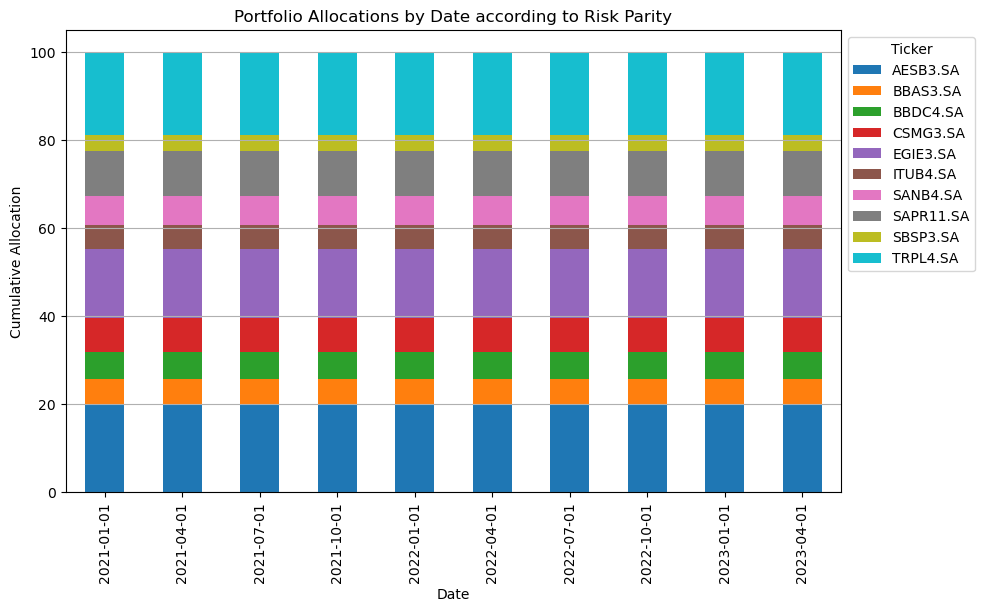

In [39]:
backtesting.plot_portfolio_over_time()

In [28]:
backtesting.plot_returns()

In [29]:
backtesting.data.loc[backtesting.rebalancing_dates[0] - timedelta(days=5): backtesting.rebalancing_dates[0] + timedelta(days=5)]

,AESB3.SA,BBAS3.SA,BBDC4.SA,CSMG3.SA,EGIE3.SA,ITUB4.SA,SANB4.SA,SAPR11.SA,SBSP3.SA,TRPL4.SA
Date,,,,,,,,,,
2020-12-28,NaN,32.429802,20.035810,13.839205,37.145214,29.081938,19.921694,22.917423,43.135887,23.158205
2020-12-29,NaN,32.240250,20.003309,13.864413,36.855274,29.018667,19.830463,22.680319,42.220512,23.472605
2020-12-30,NaN,31.976528,19.719933,13.780385,36.399654,28.593777,19.482126,21.396681,41.937405,23.009275
2021-01-04,NaN,30.979326,19.204046,13.721567,36.101437,27.947104,19.407478,21.078608,40.163280,22.951361
2021-01-05,NaN,30.657909,19.086956,13.511500,35.778358,27.766220,18.918144,20.245461,40.068909,22.802433
2021-01-06,NaN,31.358429,19.719553,13.494695,35.488426,28.580214,19.598232,19.995518,39.870731,22.661779


## Pendências
1. Na célula anterior fica claro que não há informações sobre a AESB3.SA em janeiro de 2021. Mesmo assim, no gráfico do portfolio ao longo do tempo, a AESB3.SA possui uma posição não nula. Por quê?
1. Implementar função que calcula retornos
1. Implementar função que plota retornos